# Purpose

Analyze the collated results from the 2-D fine-tuning experiments. See that notebook [here](https://github.com/myles-i/DLH_TransferLearning/blob/master/jupyter_notebooks/collate_2d_finetune_results.ipynb).

## Background

The three weight type scenarios are: 10%, 20%, and random. Weight refers to the weights of the 2-D ResNet-18v2 at the commencement of fine-tuning.

For each weight-type, we ran fine-tuning 10 times with 10 different seeds. The seed plays a role in selecting the validation set. For all three scenarios, we use the same 10 seeds so that we can get more apples-to-apples comparison between trials between different scenarios.

We use google drive mount in this notebook, but in the final report we will obtain the result files using `gdown`.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
PROJECT_DIR = '/content/drive/MyDrive/DLHProject'
RESULT_DIR = PROJECT_DIR + '/results2d/experimental_nodb'

In [3]:
! ls -lh {RESULT_DIR}

total 1.7M
-rw------- 1 root root 193K May  2 05:40 history_all.csv
-rw------- 1 root root 1.5M May  2 05:42 predictions_all.pkl


# History Analysis

We analyze validation F1 scores and look at the effects of using 10% and 20% pre-train weights on fine-tuning results.

In [4]:
import pandas as pd

In [5]:
history_all = pd.read_csv(RESULT_DIR + '/history_all.csv')

### Epochs per weight type

Average epochs of each experiment (seed) for a given scenario, for each scenario.

We see that both pre-training scenarios take **more** epochs to complete fine-tuning compared to the random scenario. The 20% scenario was slightly faster compared to the 10% scenario in fine-tuning.

In [6]:
def make_epoch_table(history_all, decimals=1):
    table = (
        history_all.groupby(['weight_type', 'seed'])
        .max()
        .groupby('weight_type')
        .agg(
            Mean=pd.NamedAgg('epoch', 'mean'),
            Std=pd.NamedAgg('epoch', 'std'),
        )
        .round(decimals)
        .reindex(['random', '10', '20'])
        .rename(index={
            'random': 'Random',
            '10': 'Pre-train 10',
            '20': 'Pre-train 20'
        })
        .reset_index()
        .rename(columns={
            'weight_type': 'Scenario',
        })
    )
    # Explicitly select columns in desired order.
    table = table[['Scenario', 'Mean', 'Std']]
    return table

make_epoch_table(history_all)

,Scenario,Mean,Std
0,Random,59.2,3.9
1,Pre-train 10,64.5,4.7
2,Pre-train 20,62.0,3.6


## Validation macro F1 by epoch

We plot the validation macro F1 scores by epoch for each of the three scenarios. This attempts to produce a plot similar to Figure 3(a) of the paper.

In [7]:
import matplotlib.pyplot as plt

def prepare_f1_for_plot(history_all):
    data = (
        history_all
        .groupby(['weight_type', 'epoch'])
        .agg(
            min=pd.NamedAgg('f1', 'min'),
            max=pd.NamedAgg('f1', 'max'),
            mean=pd.NamedAgg('f1', 'mean'),
        )
        # Move epoch from index to column
        .reset_index('epoch')
    )
    return data

prepare_f1_for_plot(history_all)

,epoch,min,max,mean
weight_type,,,,
10,0,0.015873,0.186029,0.070967
10,1,0.019968,0.241949,0.114460
10,2,0.039957,0.546582,0.224266
10,3,0.135833,0.598677,0.376239
10,4,0.257163,0.620687,0.415391
...,...,...,...,...
random,60,0.550623,0.692260,0.630560
random,61,0.648277,0.720630,0.669081
random,62,0.551731,0.741905,0.661127


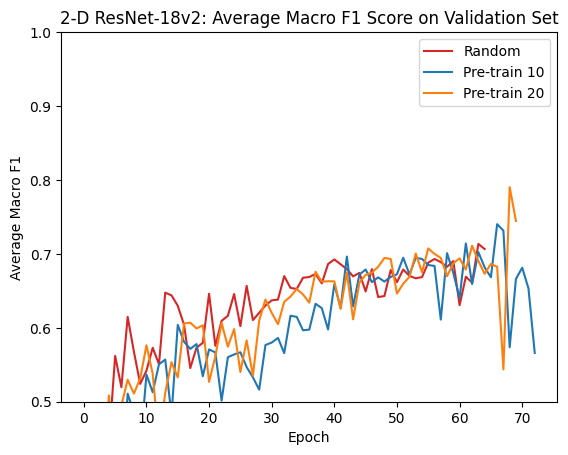

In [8]:
# can plot average macro f1 score for all 3 scenarios
# can also plot with bands for 2 scnarios, but see what 3 scenarios look like?
def plot_mean_f1_by_epoch(history_all):
    data = prepare_f1_for_plot(history_all)
    fig, ax = plt.subplots()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Average Macro F1')
    ax.set_title('2-D ResNet-18v2: Average Macro F1 Score on Validation Set')
    ax.plot(
        'epoch', 'mean', color='tab:red', data=data.loc['random'],
        label='Random'
    )
    ax.plot('epoch', 'mean', data=data.loc['10'], label='Pre-train 10')
    ax.plot('epoch', 'mean', data=data.loc['20'], label='Pre-train 20')
    ax.legend()
    # Replicate y-axis in Figure 3(a) of the paper.
    ax.set_ylim([0.5, 1.0])

plot_mean_f1_by_epoch(history_all)

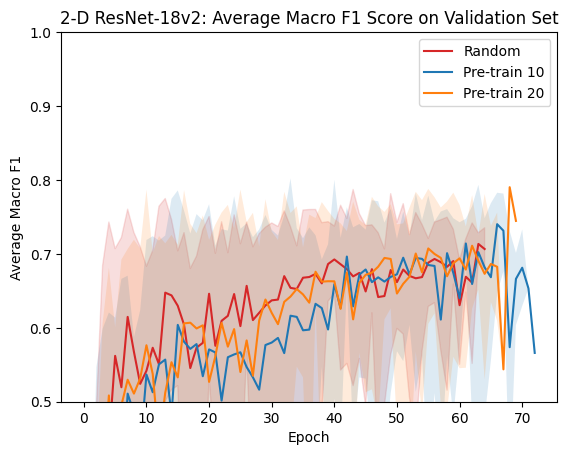

In [10]:
def plot_range_f1_by_epoch(history_all):
    # Similar as plot_mean_f1_by_epoch, but also plotting min and max F1 score
    # at each epoch for each scenario.
    data = prepare_f1_for_plot(history_all)
    fig, ax = plt.subplots()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Average Macro F1')
    ax.set_title('2-D ResNet-18v2: Average Macro F1 Score on Validation Set')
    ax.plot(
        'epoch', 'mean', color='tab:red', data=data.loc['random'],
        label='Random'
    )
    ax.plot('epoch', 'mean', data=data.loc['10'], label='Pre-train 10')
    ax.plot('epoch', 'mean', data=data.loc['20'], label='Pre-train 20')
    ax.legend()

    # Add min, max range
    ax.fill_between(
        'epoch', 'min', 'max', data=data.loc['random'], color='tab:red',
        alpha=0.15
    )
    ax.fill_between('epoch', 'min', 'max', data=data.loc['10'], alpha=0.15)
    ax.fill_between('epoch', 'min', 'max', data=data.loc['20'], alpha=0.15)
    # Replicate y-axis in Figure 3(a) of the paper.
    ax.set_ylim([0.5, 1.0])

plot_range_f1_by_epoch(history_all)

# Test prediction analysis

## Macro F1 statistics per weight type

For `load_pkl` function, we copy its implementation directly from the [source](https://github.com/myles-i/DLH_TransferLearning/blob/master/transplant/utils.py#L183) as it's simple and also this notebook is kind of a 'scratch' one so we don't bother with git cloning the project repo in an effort to move quickly.

In [11]:
# Adapted from Weimann, et al source code.
import gzip
import pickle

def load_pkl(file, compress=True):
    """ Load pickled file. """
    if compress:
        with gzip.open(file, 'rb') as fh:
            return pickle.load(fh)

In [12]:
predictions_all = load_pkl(RESULT_DIR + '/predictions_all.pkl')

In [14]:
from sklearn.metrics import f1_score
import numpy as np

def my_f1(y_true, y_prob, average='macro'):
    # set average=None to get per-class F1 scores.
    y_pred = y_prob >= np.max(y_prob, axis=1)[:, None]
    return f1_score(y_true, y_pred, average=average)

In [15]:
def make_macro_f1_table(predictions):
    macro = []
    for key, value in predictions.items():
        weight_type, seed = key.split('_')
        identifier = {'weight_type': weight_type, 'seed': seed}
        macro_f1 = my_f1(value['y_true'], value['y_prob'], average='macro')
        macro_f1 = {'f1': macro_f1}
        macro.append(identifier | macro_f1)

    macro_scores = pd.DataFrame(macro)
    macro_df = macro_scores.groupby(['weight_type'])[['f1']].agg(
        mean=pd.NamedAgg('f1', 'mean'),
        std=pd.NamedAgg('f1', 'std'),
    )
    macro_df['macro_f1'] = make_mean_std_column(
        macro_df['mean'], macro_df['std']
    )
    macro_df = macro_df[['macro_f1']]
    return macro_df

In [16]:
def make_per_class_f1_table(predictions):
    per_class = []
    for key, value in predictions.items():
        weight_type, seed = key.split('_')
        identifier = {'weight_type': weight_type, 'seed': seed}

        class_f1 = my_f1(value['y_true'], value['y_prob'], average=None)
        class_f1 = dict(zip(value['classes'], class_f1))
        per_class.append(identifier | class_f1)

    per_class_scores = pd.DataFrame(per_class)
    per_class_macro = (
        per_class_scores.groupby(['weight_type'])[['N', 'A', 'O', '~']]
        .agg(**{
            'N_mean': pd.NamedAgg('N', 'mean'),
            'A_mean': pd.NamedAgg('A', 'mean'),
            'O_mean': pd.NamedAgg('O', 'mean'),
            '~_mean': pd.NamedAgg('~', 'mean'),
            'N_std': pd.NamedAgg('N', 'std'),
            'A_std': pd.NamedAgg('A', 'std'),
            'O_std': pd.NamedAgg('O', 'std'),
            '~_std': pd.NamedAgg('~', 'std'),
        })
    )

    per_class_macro['N_f1'] = make_mean_std_column(
        per_class_macro['N_mean'], per_class_macro['N_std']
    )
    per_class_macro['A_f1'] = make_mean_std_column(
        per_class_macro['A_mean'], per_class_macro['A_std']
    )
    per_class_macro['O_f1'] = make_mean_std_column(
        per_class_macro['O_mean'], per_class_macro['O_std']
    )
    per_class_macro['~_f1'] = make_mean_std_column(
        per_class_macro['~_mean'], per_class_macro['~_std'],
    )
    per_class_macro = per_class_macro[['N_f1', 'A_f1', 'O_f1', '~_f1']]
    return per_class_macro

In [17]:
def make_mean_std_column(mean_col, std_col, decimals=3):
    """
    Helper to produce column values formatted like in Table 1 of the paper.
    """
    # Account for decimal, and assume the leading zero is stripped.
    return (
        mean_col.astype(str)
        # 1: decimal point's index, e.g.: '0.xxx'
        # 1 + decimals + 1: (decimals + 1) is total string length, counting
        # the decimal point itself. The (1 +) is because we started the
        # substring at index 1.
        .str[1 : 1 + decimals + 1]
        .str.pad(decimals + 1, side='right', fillchar='0')
        # TODO: may need to replace \u00b1 with '+/-' if it doesn't render
        # correctly in nbconvert
        + ' (\u00b1 '
        + std_col.astype(str)
        .str[1 : 1 + decimals + 1]
        .str.pad(decimals + 1, side='right', fillchar='0')
        + ')'
    )

In [18]:
def make_f1_table(predictions):
    macro_f1 = make_macro_f1_table(predictions)
    per_class_f1 = make_per_class_f1_table(predictions)
    table = (
        macro_f1.join(per_class_f1)
        .reindex(['random', '10', '20'])
        .rename(index={
            'random': 'Random',
            '10': 'Pre-train 10',
            '20': 'Pre-train 20',
        })
        .reset_index()
        # Using same names as Table 1
        .rename(columns={
            'weight_type': 'Scenario',
            'macro_f1': 'F1',
            'N_f1': 'F1n', # Normal
            'A_f1': 'F1a', # AF
            'O_f1': 'F1o', # Other
            '~_f1': 'F1p', # Noisy
        })
    )
    # Explicitly select columns in desired order.
    table = table[['Scenario', 'F1', 'F1n', 'F1a', 'F1o', 'F1p']]
    return table

make_f1_table(predictions_all)

,Scenario,F1,F1n,F1a,F1o,F1p
0,Random,.721 (± .010),.887 (± .012),.698 (± .025),.706 (± .014),.594 (± .042)
1,Pre-train 10,.729 (± .021),.890 (± .010),.692 (± .039),.700 (± .021),.635 (± .056)
2,Pre-train 20,.727 (± .018),.889 (± .006),.705 (± .024),.693 (± .025),.621 (± .055)
